# Convolution Function

In [3]:
import numpy as np

def Convolution(image, filter, stride=1, padding=0):
    """
    Question (a)
    Implement your own conv function which performs convolution operation without using any neural network packages.
    Make sure to handle all possible edge cases to receive full credits as your implementation will be tested with 20 test cases (1 pt for each test case).
    Keep in mind that height and width of the given image or filter are not always the same.

    Inputs
    - image: 2D numpy array 
    - filter: 2D numpy array
    - stride, padding: integers

    Outputs:
    - 2D numpy array : convolution results of the given image and filter..
    - Return None if stride is not compatible. (ex. image of 5*5 with filter 2*2 with stride 2, padding 0)
    - Return None if filter is larger than the given image.
    """

    ### COMPLETE HERE ###
    W, H = image.shape
    F_W, F_H = filter.shape
    
    if (W-F_W+2*padding < 0 or H-F_H+2*padding < 0):
      return None
    if ((W-F_W+2*padding) % stride != 0 or (H-F_H+2*padding) % stride != 0):
       return None
    output_W, output_H = int((W-F_W+2*padding)/stride) + 1, int((H-F_H+2*padding)/stride) + 1
    image = np.pad(image, ((padding,padding),(padding,padding)), 'constant', constant_values=0)
    output = np.zeros((output_W,output_H))
    for i in range(output_W):
      for j in range(output_H):
        output[i,j] = np.sum(np.multiply(image[i*stride:i*stride+F_W, j*stride:j*stride+F_H], filter))
    ### COMPLETE HERE ###
    
    return output

In [4]:
Convolution(np.array([[1, 2, 3, 2, 1], [2, 3, 4, 5, 6], [-1, -2, -3, -4, -5], [0, 0, 1, 0, 0], [7, 1, 7, 1, 7]]), np.array([[1, 0], [0, 1]]), stride=3, padding=0)
## Expected result:
# array([[4., 8.],
#        [1., 7.]])

array([[4., 8.],
       [1., 7.]])

# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/study/Github/MLDL1/HW3

/content/drive/MyDrive/study/Github/MLDL1/HW3


# Import Modules

In [5]:
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [ ]:
"""
import modules you need
"""


# Utils

In [6]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this function.
    """
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

In [7]:
def train(model, train_loader, optimizer):
    """
    Trains the model with training data.

    Do NOT modify this function.
    """
    model.train()
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))


def evaluate(model, test_loader):
    """
    Evaluates the trained model with test data.

    Do NOT modify this function.
    """
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# CIFAR-10 Data Augmentation

In [31]:
def gaussian_smoothing(image, filter_size=3, sigma=1.0):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    center = (filter_size-1)/2
    gaussian_filter = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        for col in range(filter_size):
            gaussian_filter[row, col] = np.exp((-(row-center) ** 2 - (col-center) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)
    image = cv2.filter2D(image, -1, gaussian_filter)
    return image

def color_jitter(image):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return image

def custom_augmentation(image):
    """
      Define your own augmentation without using neural network libraries.

      Extra Credit Question (b)
      - You can use opencv library for this question.

      Inputs
      - image: an input image of shape (3,32,32).
      Returns
      - image: image after applying your custom augmentation.
    """
    ### COMPLETE HERE ###
    H, W = image.shape[:2]
    padding = np.random.randint(0,3)
    position_x = padding
    position_y= padding
    H_zoom = H - 2 * padding
    W_zoom = W - 2 * padding
    image = image[position_x:position_x+H_zoom, position_y:position_y+W_zoom, :]
    image = cv2.resize(image, (H,W), cv2.INTER_CUBIC)
    image = cv2.flip(image,1)
    ### COMPLETE HERE ###

    return image

Files already downloaded and verified


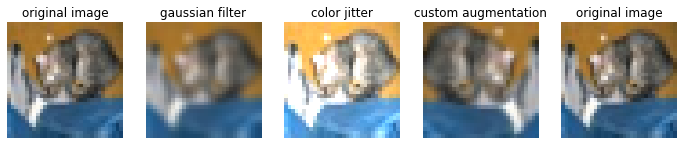

In [32]:
"""
Visualize how the augmentations are applied to a single image.
You can run this block of code to check how your custom augmentation function from (b) is applied.

Do NOT modify.
"""

raw_test = datasets.CIFAR10(root="./CIFAR_10", train=False, download=True)

f, ax = plt.subplots(1, 5)
f.set_size_inches(12, 3)
x = raw_test[0][0]
x = np.array(x)
g = gaussian_smoothing(x)
j = color_jitter(x)
c = custom_augmentation(x)
title = ['original image', 'gaussian filter', 'color jitter', 'custom augmentation', 'original image']
for i, img in enumerate([x, g, j, c, x]):
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(title[i], color='k')

In [ ]:
### 
# Extra Credit Question (b)
# (1) Briefly describe what your custom_augmentation function does.
# (2) Using the visualization results shown above, explain why you believe your custom augmentation function is useful for image classification task.
###

(1) image의 테두리를 0~2개 두께로 없애고 확대하고, image를 좌우 반전한다.  
(2) 앞서 구현한 custom augmentation을 통해 image에서 classification target을 둘러싼 배경 부분을 고려하지 않을 수 있게 되어 image에서 해당 target의 비중을 높일 수 있고, 좌우 반전된 target 역시 model training에 반영할 수 있다.  

In [33]:
class CustomDataset(Dataset):
    def __init__(self, train, prob=0.5, data_dir="./CIFAR_10"):
        """
        Do NOT modify this method.
        """
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.prob = prob

    def __len__(self):
        """
        Do NOT modify this method.
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Do NOT modify this method.
        """
        return self.data[idx]
    
    def transform(self, image):
        """
          Apply stochastic data augmentation to the given image.

          Question (c)
          - Convert the given RGB image into BGR scale using opencv library.
          - Apply random augmentation (gaussian smoothing and color jitter, custom_augmentation if implemented).
            - Random augmentation is applied with the probability of self.prob.
            - If self.prob = 0.5, 5 out of 10 images will be augmented on average.
          - Convert the augmented image back to RGB scale for training.

          Inputs
          - image: numpy array of an input image of shape (32,32,3).
          Returns
          - image: numpy array of the augmented input image with shape (32,32,3).
        """
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        ### COMPLETE HERE ###
        if np.random.rand() < self.prob:
            image = gaussian_smoothing(image)
        if np.random.rand() < self.prob:
            image = color_jitter(image)
        if np.random.rand() < self.prob:
            image = custom_augmentation(image)
        
        ### COMPLETE HERE ###
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def collate_fn(self, data):
        """
        Creates a batch of images and label tensors.

        Question (d)
        - Convert each image in the batch from PIL image to numpy array.
        - Transform the image using self.transform method to apply random augmentation.
        - Normalize the transformed image by mapping the range [0, 255] to range [0, 1].
        - Transpose the (H * W * C) format of the image into (C * H * W) format.
          - To be specific, the dimension of the original image is (32, 32, 3).
          - We want the dimension of the transposed image to be (3, 32, 32).
        - Convert the batch of preprocessed images into PyTorch float tensors.
        - Convert the batch of labels into PyTorch long tensors.
        - Do NOT use torchvision.transforms library!

        Inputs
        - list of tuples, each containing a PIL image and an integer label
        - number of tuples in the list == BATCH SIZE
        Returns
        - batch of image tensors, batch of label tensors
        - size: (BATCH, CHANNEL, HEIGHT, WIDTH), (BATCH)
        """
        batch_x, batch_y = [], []

        ### COMPLETE HERE ###
        for x, y in data:
          x = np.array(x)
          if self.transform is not None:
            x = self.transform(x)
          # x = transforms.ToTensor()(x)
          x = x / 255
          x = x.transpose(2,0,1)
          x = torch.Tensor(x)
          y = torch.Tensor([y])
          batch_x.append(x)
          batch_y.append(y)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.cat(batch_y).long()
        ### COMPLETE HERE ###

        return batch_x, batch_y
    

Files already downloaded and verified


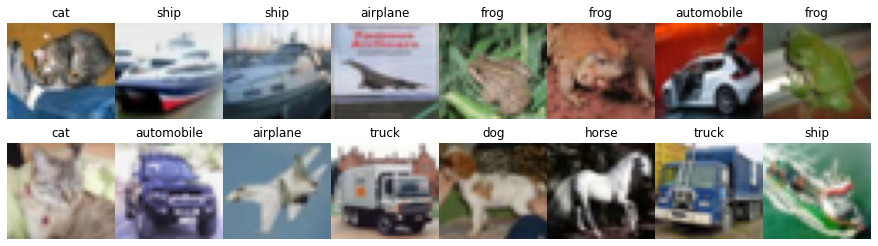

In [34]:
"""
Plot some example images and class labels without applying data augmentation.

Do NOT modify.
"""

raw_test_dataset = CustomDataset(train=False, prob=0, data_dir="./CIFAR_10")
raw_test_loader = DataLoader(dataset=raw_test_dataset, batch_size=16, shuffle=False, collate_fn=raw_test_dataset.collate_fn)

plot_dataset(raw_test_loader)

Files already downloaded and verified
Files already downloaded and verified


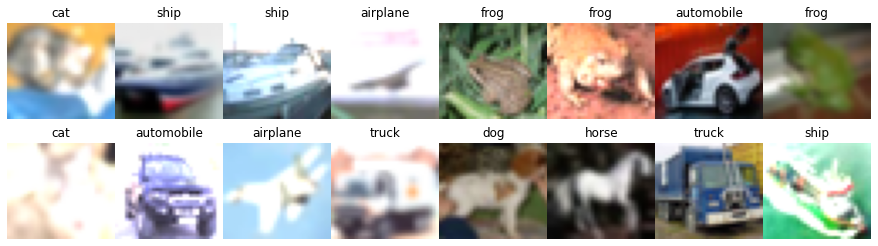

In [35]:
"""
Same examples after applying data augmentation with 50% probability.
If your transform (c) and collate_fn (d) methods have been implemented well, some of the results should look different from the ones above.

Do NOT modify.
"""

train_dataset = CustomDataset(train=True, prob=0.5)
test_dataset = CustomDataset(train=False, prob=0.5)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         collate_fn=test_dataset.collate_fn)

plot_dataset(test_loader)

# ConvNet Image Classification

In [36]:
### 
# Question (e)
# Train your ConvNet to achieve test accuracy above 60%
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
###

In [37]:
class ConvNet(nn.Module):
    """
    Builds a ConvNet model.

    Question (e)
    - things that might be useful...
    - stack [Conv2D + Conv2D + MaxPool2D] at least three times, 
    - follwed by at least three Linear layers.
    - 3x3 filter is enough, but feel free to use larger filter size.
    - channels used: [10, 32, 64, 128, 256, 512, 1024]
    - you can choose smaller or larger channel size as well.
    - The model may include BatchNormalization, regularizers, and Dropout, but they are not necessary.
    """
    def __init__(self):
        """
        Define the layers that you would like to use in your model.
        """
        super(ConvNet, self).__init__()

        ### COMPLETE HERE ###
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1) # output size: 32*32
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 32, kernel_size = 3, padding = 1) # output size: 32*32
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1) # input size: 16*16, output size: 16*16
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1) # input size: 16*16, output size: 16*16
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1) # input size: 8*8, output size: 8*8
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1) # input size: 8*8, output size: 8*8
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(4 * 4 * 512, 4 * 512)
        self.fc2 = nn.Linear(4 * 512, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)
        ### COMPLETE HERE ###
    
    def forward(self, x):
        """
        Apply forward pass of the given batch of input images.
        Inputs
        - x: batch of input images.
        Returns
        - softmax probabilites of the input image for each class label
        """

        ### COMPLETE HERE ###
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 4 * 4 * 512)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        ### COMPLETE HERE ###

        return x

In [38]:
"""
Make sure your runtime type is GPU and you are using PyTorch version higher than 1.8!

Do NOT modify.
"""

DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 1.11.0+cu113, Device: cuda


In [56]:
"""
Load your customized model "ConvNet" and its training settings.
You may choose the number of epochs that you would like to train.
You might want to use different optimizers or learning rates.
"""

EPOCHS = 10
model = ConvNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
criterion = nn.CrossEntropyLoss()

print(model)

ConvNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)


In [57]:
"""
Train your model "ConvNet" with the augmented CIFAR-10 dataset.
Upon successful training, test accuracy of your model should be above 70%.

Do NOT modify.
"""

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: ConvNet, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: ConvNet, 	Test Loss: 0.0251, 	Test Accuracy: 40.00 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: ConvNet, 	Test Loss: 0.0211, 	Test Accuracy: 52.21 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: ConvNet, 	Test Loss: 0.0184, 	Test Accuracy: 58.93 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: ConvNet, 	Test Loss: 0.0161, 	Test Accuracy: 64.06 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: ConvNet, 	Test Loss: 0.0146, 	Test Accuracy: 67.62 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: ConvNet, 	Test Loss: 0.0135, 	Test Accuracy: 70.95 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: ConvNet, 	Test Loss: 0.0131, 	Test Accuracy: 71.29 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: ConvNet, 	Test Loss: 0.0129, 	Test Accuracy: 71.83 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: ConvNet, 	Test Loss: 0.0123, 	Test Accuracy: 73.41 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: ConvNet, 	Test Loss: 0.0122, 	Test Accuracy: 73.87 % 

